# Concise Implementation of Linear Regression
:label:`sec_linear_concise`

Deep learning has witnessed a sort of Cambrian explosion
over the past decade.
The sheer number of techniques, applications and algorithms by far surpasses the
progress of previous decades. 
This is due to a fortuitous combination of multiple factors,
one of which is the powerful free tools
offered by a number of open-source deep learning frameworks.
Theano :cite:`Bergstra.Breuleux.Bastien.ea.2010`,
DistBelief :cite:`Dean.Corrado.Monga.ea.2012`,
and Caffe :cite:`Jia.Shelhamer.Donahue.ea.2014`
arguably represent the
first generation of such models 
that found widespread adoption.
In contrast to earlier (seminal) works like
SN2 (Simulateur Neuristique) :cite:`Bottou.Le-Cun.1988`,
which provided a Lisp-like programming experience,
modern frameworks offer automatic differentiation
and the convenience of Python.
These frameworks allow us to automate and modularize
the repetitive work of implementing gradient-based learning algorithms.

In :numref:`sec_linear_scratch`, we relied only on
(i) tensors for data storage and linear algebra;
and (ii) automatic differentiation for calculating gradients.
In practice, because data iterators, loss functions, optimizers,
and neural network layers
are so common, modern libraries implement these components for us as well.
In this section, (**we will show you how to implement
the linear regression model**) from :numref:`sec_linear_scratch`
(**concisely by using high-level APIs**) of deep learning frameworks.

# 선형 회귀의 간결한 구현
:label:`sec_linear_concise`

딥 러닝은 지난 10년 동안 캄브리아기 폭발과 같은 급격한 발전을 경험했습니다.엄청난 양의 기술, 응용 프로그램, 알고리즘이 개발되면서 지난 수십 년간의 발전을 훨씬 뛰어넘었습니다.이는 여러 요인의 우연한 조합 덕분인데,
그중 하나는 여러 오픈소스 딥 러닝 프레임워크에서 제공하는 강력한 무료 도구입니다.Theano(:cite:`Bergstra.Breuleux.Bastien.ea.2010`),
DistBelief(:cite:`Dean.Corrado.Monga.ea.2012`),
Caffe(:cite:`Jia.Shelhamer.Donahue.ea.2014`)는 널리 채택된 이러한 모델의 첫 번째 세대를 대표한다고 할 수 있습니다.Lisp와 유사한 프로그래밍 경험을 제공했던
SN2(신경 시뮬레이터) :cite:`Bottou.Le-Cun.1988`와 같은 초기(획기적인) 작업과는 달리,
최신 프레임워크는 자동 미분과
Python의 편의성을 제공합니다.이러한 프레임워크를 통해 기울기 기반 학습 알고리즘 구현의 반복적인 작업을 자동화하고 모듈화할 수 있습니다.:numref:`sec_linear_scratch`에서는
(i) 데이터 저장 및 선형 대수를 위한 텐서,
(ii) 기울기 계산을 위한 자동 미분에만 의존했습니다.실제로 데이터 반복자, 손실 함수, 옵티마이저,
신경망 계층은 매우 일반적이기 때문에
최신 라이브러리는 이러한 구성 요소도 자동으로 구현합니다.이 섹션에서는 (**:numref:`sec_linear_scratch`를 사용하여
선형 회귀 모델을 구현하는 방법을 보여드리겠습니다.**)
(**고수준 API를 사용하여 간략하게**) 딥러닝 프레임워크를 다룹니다.


In [1]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## Defining the Model

When we implemented linear regression from scratch
in :numref:`sec_linear_scratch`,
we defined our model parameters explicitly
and coded up the calculations to produce output
using basic linear algebra operations.
You *should* know how to do this.
But once your models get more complex,
and once you have to do this nearly every day,
you will be glad of the assistance.
The situation is similar to coding up your own blog from scratch.
Doing it once or twice is rewarding and instructive,
but you would be a lousy web developer
if you spent a month reinventing the wheel.

For standard operations,
we can [**use a framework's predefined layers,**]
which allow us to focus
on the layers used to construct the model
rather than worrying about their implementation.
Recall the architecture of a single-layer network
as described in :numref:`fig_single_neuron`.
The layer is called *fully connected*,
since each of its inputs is connected
to each of its outputs
by means of a matrix--vector multiplication.

## 모델 정의

:numref:`sec_linear_scratch`에서 선형 회귀를 처음부터 구현할 때,
모델 매개변수를 명시적으로 정의하고
기본적인 선형 대수 연산을 사용하여 출력을 생성하는 계산을 코딩했습니다.이 작업을 수행하는 방법은 이미 알고 계실 겁니다.하지만 모델이 더 복잡해지고
거의 매일 이 작업을 수행해야 한다면
도움이 될 것입니다.이 상황은 블로그를 처음부터 코딩하는 것과 비슷합니다.한두 번 정도 해 보면 보람 있고 유익하지만
한 달 동안 바퀴를 새로 만드는 데 시간을 허비한다면
형편없는 웹 개발자가 될 것입니다.표준 연산의 경우
[**프레임워크의 미리 정의된 레이어를 사용**]할 수 있습니다. 이를 통해
모델을 구성하는 데 사용된 레이어에 집중할 수 있으며
구현에 신경 쓸 필요가 없습니다.:numref:`fig_single_neuron`에서 설명한 단일 레이어 네트워크의 아키텍처를 생각해 보세요.이 계층은 *완전 연결* 계층이라고 합니다.
각 입력이 행렬-벡터 곱셈을 통해
각 출력에 연결되어 있기 때문입니다.


In PyTorch, the fully connected layer is defined in `Linear` and `LazyLinear` classes (available since version 1.8.0). 
The latter
allows users to specify *merely*
the output dimension,
while the former
additionally asks for
how many inputs go into this layer.
Specifying input shapes is inconvenient and may require nontrivial calculations
(such as in convolutional layers).
Thus, for simplicity, we will use such "lazy" layers
whenever we can.

PyTorch에서 완전 연결 계층은 `Linear` 및 `LazyLinear` 클래스(1.8.0 버전부터 사용 가능)에 정의되어 있습니다.후자는 사용자가 *단지* 출력 차원만 지정할 수 있도록 하는 반면, `LazyLinear`는 이 계층에 몇 개의 입력을 입력할지 추가로 묻습니다.입력 형태를 지정하는 것은 불편하며, (합성곱 계층과 같은)
간단하지 않은 계산이 필요할 수 있습니다.따라서 단순화를 위해 가능한 한 이러한 "지연" 계층을 사용할 것입니다.


In [2]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In the `forward` method we just invoke the built-in `__call__` method of the predefined layers to compute the outputs.

`forward` 메서드에서는 미리 정의된 레이어의 내장 `__call__` 메서드를 호출하여 출력을 계산합니다.


In [3]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

## Defining the Loss Function

## 손실 함수 정의


[**The `MSELoss` class computes the mean squared error (without the $1/2$ factor in :eqref:`eq_mse`).**]
By default, `MSELoss` returns the average loss over examples.
It is faster (and easier to use) than implementing our own.

[**`MSELoss` 클래스는 평균 제곱 오차( :eqref:`eq_mse`의 $1/2$ 요소 제외)를 계산합니다.**]
기본적으로 `MSELoss`는 예제에 대한 평균 손실을 반환합니다.이 방법은 직접 구현하는 것보다 더 빠르고 사용하기도 쉽습니다.


In [4]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

## Defining the Optimization Algorithm

## 최적화 알고리즘 정의


Minibatch SGD is a standard tool
for optimizing neural networks
and thus PyTorch supports it alongside a number of
variations on this algorithm in the `optim` module.
When we (**instantiate an `SGD` instance,**)
we specify the parameters to optimize over,
obtainable from our model via `self.parameters()`,
and the learning rate (`self.lr`)
required by our optimization algorithm.

미니배치 SGD는 신경망 최적화를 위한 표준 도구이며, PyTorch는 `optim` 모듈에서 이 알고리즘의 다양한 변형과 함께 미니배치 SGD를 지원합니다.(**`SGD` 인스턴스를 인스턴스화**할 때) `self.parameters()`를 통해 모델에서 얻을 수 있는 최적화 대상 매개변수와 최적화 알고리즘에 필요한 학습률(`self.lr`)을 지정합니다.


In [5]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

## Training

You might have noticed that expressing our model through
high-level APIs of a deep learning framework
requires fewer lines of code.
We did not have to allocate parameters individually,
define our loss function, or implement minibatch SGD.
Once we start working with much more complex models,
the advantages of the high-level API will grow considerably.

Now that we have all the basic pieces in place,
[**the training loop itself is the same
as the one we implemented from scratch.**]
So we just call the `fit` method (introduced in :numref:`oo-design-training`),
which relies on the implementation of the `fit_epoch` method
in :numref:`sec_linear_scratch`,
to train our model.

## 학습

딥 러닝 프레임워크의 고수준 API를 통해 모델을 표현하는 것이
코드 줄 수를 줄인다는 것을 눈치채셨을 것입니다.매개변수를 개별적으로 할당하거나,
손실 함수를 정의하거나, 미니배치 SGD를 구현할 필요가 없었습니다.훨씬 더 복잡한 모델을 다루기 시작하면
고수준 API의 이점이 상당히 커질 것입니다.이제 모든 기본 요소가 준비되었으므로
[**학습 루프 자체는
처음부터 구현한 루프와 동일합니다.**]
따라서 :numref:`oo-design-training`에서 소개된 `fit` 메서드를 호출하기만 하면 됩니다.
이 메서드는 :numref:`sec_linear_scratch`에서 구현된 `fit_epoch` 메서드를 사용하여
모델을 학습시킵니다.


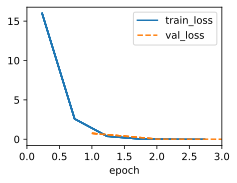

In [6]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Below, we
[**compare the model parameters learned
by training on finite data
and the actual parameters**]
that generated our dataset.
To access parameters,
we access the weights and bias
of the layer that we need.
As in our implementation from scratch,
note that our estimated parameters
are close to their true counterparts.

아래에서는
[**유한한 데이터로 학습하여 학습한 모델 매개변수와
데이터셋을 생성한 실제 매개변수를 비교합니다.**]
매개변수에 접근하기 위해
필요한 계층의 가중치와 편향에 접근합니다.처음부터 구현할 때와 마찬가지로
추정된 매개변수가 실제 매개변수와 거의 일치한다는 점에 유의하세요.


In [7]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

In [8]:
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0084, -0.0149])
error in estimating b: tensor([0.0099])


## Summary

This section contains the first
implementation of a deep network (in this book)
to tap into the conveniences afforded
by modern deep learning frameworks,
such as MXNet :cite:`Chen.Li.Li.ea.2015`, 
JAX :cite:`Frostig.Johnson.Leary.2018`, 
PyTorch :cite:`Paszke.Gross.Massa.ea.2019`, 
and Tensorflow :cite:`Abadi.Barham.Chen.ea.2016`.
We used framework defaults for loading data, defining a layer,
a loss function, an optimizer and a training loop.
Whenever the framework provides all necessary features,
it is generally a good idea to use them,
since the library implementations of these components
tend to be heavily optimized for performance
and properly tested for reliability.
At the same time, try not to forget
that these modules *can* be implemented directly.
This is especially important for aspiring researchers
who wish to live on the leading edge of model development,
where you will be inventing new components
that cannot possibly exist in any current library.

## 요약

이 섹션에서는 MXNet(Chen.Li.Li.ea.2015), JAX(Frostig.Johnson.Leary.2018), PyTorch(Paszke.Gross.Massa.ea.2019), Tensorflow(Abadi.Barham.Chen.ea.2016)와 같은 최신 딥 러닝 프레임워크의 편의성을 활용하기 위한 딥 네트워크(이 책에서 처음 구현)를 소개합니다.데이터 로딩, 계층 정의, 손실 함수, 옵티마이저 및 학습 루프를 위해 프레임워크 기본값을 사용했습니다.프레임워크가 필요한 모든 기능을 제공하는 경우,
일반적으로 이러한 구성 요소의 라이브러리 구현은 성능 최적화를 위해 고도로 최적화되고 신뢰성을 위해 적절하게 테스트되는 경향이 있으므로 프레임워크 기본값을 사용하는 것이 좋습니다.동시에, 이러한 모듈은 직접 구현할 수 있다는 점을 잊지 마세요.특히, 모델 개발의 선두에서 살고 싶어 하는 야심 찬 연구자들에게는 더욱 중요합니다.
현재 어떤 라이브러리에도 존재할 수 없는 새로운 구성 요소를 개발하게 될 것입니다.


In PyTorch, the `data` module provides tools for data processing,
the `nn` module defines a large number of neural network layers and common loss functions.
We can initialize the parameters by replacing their values
with methods ending with `_`.
Note that we need to specify the input dimensions of the network.
While this is trivial for now, it can have significant knock-on effects
when we want to design complex networks with many layers.
Careful considerations of how to parametrize these networks
is needed to allow portability.

PyTorch에서 `data` 모듈은 데이터 처리 도구를 제공하고,
`nn` 모듈은 다수의 신경망 계층과 일반적인 손실 함수를 정의합니다.`_`로 끝나는 메서드로 값을 대체하여 매개변수를 초기화할 수 있습니다.네트워크의 입력 차원을 지정해야 합니다.지금은 간단하지만, 여러 계층을 가진 복잡한 네트워크를 설계할 때는 상당한 영향을 미칠 수 있습니다.이식성을 확보하려면 이러한 네트워크를 매개변수화하는 방법에 대한 신중한 고려가 필요합니다.


## Exercises
## 연습

1. How would you need to change the learning rate if you replace the aggregate loss over the minibatch
   with an average over the loss on the minibatch?
1. 미니배치의 총 손실을 미니배치 손실의 평균으로 대체하는 경우 학습률을 어떻게 변경해야 합니까?
미니배치에 대한 손실을 총합(sum)에서 평균(average)으로 변경하면, **학습률을 비례적으로 늘려야 할 필요가 있을 수 있습니다.** 📈

---

## 손실 함수 변경의 영향

### 1. 손실 총합 vs. 손실 평균
* **총합 손실 (Sum Loss)**: 미니배치 내의 모든 샘플에 대한 손실 값을 단순히 합산합니다. 배치 크기가 $B$이고 각 샘플 $i$에 대한 손실이 $L_i$라면, 총합 손실은 $\sum_{i=1}^{B} L_i$가 됩니다.
* **평균 손실 (Average Loss)**: 미니배치 내의 모든 샘플에 대한 손실 값을 합산한 후 배치 크기 $B$로 나눕니다. 평균 손실은 $\frac{1}{B} \sum_{i=1}^{B} L_i$가 됩니다.

### 2. 기울기(Gradient)에 미치는 영향
최적화 알고리즘은 손실 함수의 기울기를 계산하여 매개변수를 업데이트합니다.
* **총합 손실의 기울기**: 손실 총합에 대한 기울기는 각 샘플의 기울기를 합산한 것과 같습니다. 즉, $\nabla (\sum L_i) = \sum \nabla L_i$ 입니다.
* **평균 손실의 기울기**: 손실 평균에 대한 기울기는 각 샘플의 기울기를 합산한 후 배치 크기 $B$로 나눈 것과 같습니다. 즉, $\nabla (\frac{1}{B} \sum L_i) = \frac{1}{B} \sum \nabla L_i$ 입니다.

여기서 중요한 점은 **평균 손실을 사용하면 계산된 기울기의 크기가 총합 손실을 사용할 때보다 배치 크기 $B$만큼 작아진다는 것**입니다.

### 3. 학습률 변경의 필요성
매개변수 업데이트 규칙은 일반적으로 다음과 같습니다:
$\theta \leftarrow \theta - \text{학습률} \times \text{기울기}$

* **총합 손실 사용 시**: $\theta \leftarrow \theta - \text{학습률}_{\text{sum}} \times (\sum \nabla L_i)$
* **평균 손실 사용 시**: $\theta \leftarrow \theta - \text{학습률}_{\text{avg}} \times (\frac{1}{B} \sum \nabla L_i)$

만약 우리가 동일한 양의 매개변수 업데이트를 원한다면, 즉 **기울기 업데이트의 '크기'를 동일하게 유지하고 싶다면**, 평균 손실을 사용할 때 학습률을 더 크게 설정해야 합니다.

$\text{학습률}_{\text{sum}} \times (\sum \nabla L_i) = \text{학습률}_{\text{avg}} \times (\frac{1}{B} \sum \nabla L_i)$

위 식에서 $(\sum \nabla L_i)$ 항을 소거하면:

$\text{학습률}_{\text{sum}} = \text{학습률}_{\text{avg}} / B$
또는
$\text{학습률}_{\text{avg}} = \text{학습률}_{\text{sum}} \times B$

따라서, 미니배치 손실을 총합에서 평균으로 변경할 경우, **평균 손실에 대한 학습률($\text{학습률}_{\text{avg}}$)은 총합 손실에 대한 학습률($\text{학습률}_{\text{sum}}$)에 배치 크기 $B$를 곱한 값으로 설정**해야 합니다. 즉, **학습률을 배치 크기만큼 늘려야 합니다.**

---

## 실제 적용과 고려사항

실제로 대부분의 딥러닝 프레임워크와 구현에서는 손실 함수를 계산할 때 **기본적으로 미니배치에 대한 평균 손실을 사용**합니다. 이는 배치 크기가 바뀌더라도 학습률을 크게 조정할 필요 없이 일관된 학습 거동을 유지할 수 있기 때문입니다. 만약 당신이 직접 손실 함수를 구현하여 총합 손실을 반환하도록 했다가 평균 손실로 바꾸는 경우라면, 위에서 설명한 대로 학습률을 조정해야 합니다.

**요약하자면,** 미니배치 손실을 총합에서 평균으로 바꾸면 기울기 크기가 배치 크기만큼 작아지므로, **동일한 학습 효과를 유지하기 위해서는 학습률을 배치 크기만큼 늘려야 합니다.**



1. Review the framework documentation to see which loss functions are provided. In particular,
   replace the squared loss with Huber's robust loss function. That is, use the loss function
   $$l(y,y') = \begin{cases}|y-y'| -\frac{\sigma}{2} & \textrm{ if } |y-y'| > \sigma \\ \frac{1}{2 \sigma} (y-y')^2 & \textrm{ otherwise}\end{cases}$$
1. 프레임워크 설명서를 검토하여 어떤 손실 함수가 제공되는지 확인하세요.특히 제곱 손실을 Huber의 강건 손실 함수로 대체하세요.즉, 다음 손실 함수를 사용하세요.
$$l(y,y') = \begin{cases}|y-y'|-\frac{\sigma}{2} & \textrm{ if } |y-y'|> \sigma \\ \frac{1}{2 \sigma} (y-y')^2 & \textrm{ otherwise}\end{cases}$$

각주에 명시된 후버 손실 함수의 수식은 일반적인 정의와 다소 차이가 있습니다. 제시된 수식은 아래와 같으므로, 이에 따라 후버 손실 함수를 구현하고 설명을 진행하겠습니다.

$$
l(y,y') =
\begin{cases}
    |y - y'| - \frac{1}{2}\sigma & \text{if } |y - y'| > \sigma \\
    \frac{1}{2\sigma}(y - y')^2 & \text{otherwise}
\end{cases}
$$

일반적으로 딥러닝 프레임워크는 다양한 손실 함수를 제공하며, `torch.nn.MSELoss` (평균 제곱 오차), `torch.nn.L1Loss` (평균 절대 오차) 등이 대표적입니다. 후버 손실(Huber Loss)은 PyTorch의 `torch.nn.HuberLoss`와 같은 형태로 직접 제공되기도 합니다.

---

## Huber 손실 함수 구현 및 설명 ⚖️

주어진 수식에 따라 후버 손실 함수를 구현해 보겠습니다. 이 손실 함수는 오차의 크기에 따라 제곱 항과 절대값 항을 다르게 적용하여, 이상치에 덜 민감하면서도 최적화가 용이하도록 설계되었습니다.

### 1. Huber 손실 함수 구현

제시된 수식 $l(y,y') = \frac{1}{2\sigma}(y-y')^2$ (if $|y-y'| \le \sigma$)와 $l(y,y') = |y-y'| - \frac{1}{2}\sigma$ (if $|y-y'| > \sigma$)에 따라 PyTorch로 구현합니다.

```python
import torch
from torch import nn

def huber_loss_custom(y_hat, y, sigma=1.0):
    """
    주어진 수식에 따른 Huber 손실 함수 구현.
    y_hat: 예측값
    y: 실제값
    sigma: 임계값 (델타 값)
    """
    diff = torch.abs(y_hat - y)
    
    # |y - y'| <= sigma 인 경우
    # 0.5 * (diff**2) / sigma
    loss_small = 0.5 * (diff**2) / sigma 
    
    # |y - y'| > sigma 인 경우
    # diff - 0.5 * sigma
    loss_large = diff - 0.5 * sigma
    
    # torch.where를 사용하여 조건에 따라 손실 값 선택
    loss = torch.where(diff <= sigma, loss_small, loss_large)
    
    return loss.mean() # 일반적으로 배치 평균을 반환

# 예시 사용
y_hat = torch.tensor([1.0, 2.0, 3.0, 10.0, 20.0])
y = torch.tensor([1.1, 2.2, 2.9, 0.0, 100.0]) # 0.0과 100.0은 이상치
sigma_val = 1.0

custom_huber = huber_loss_custom(y_hat, y, sigma_val)
print(f"커스텀 Huber 손실: {custom_huber.item()}")

# PyTorch 내장 HuberLoss (기본 delta=1.0)와 비교
# PyTorch의 HuberLoss 공식은 0.5 * ((y-y')**2) 또는 delta * (|y-y'| - 0.5 * delta)
# 이는 주어진 문제의 수식과 계수에서 약간 차이가 있음.
# 따라서 직접 구현한 것과 내장 함수는 결과값이 다르게 나옴.
# torch_huber_loss_fn = nn.HuberLoss(delta=sigma_val)
# torch_huber = torch_huber_loss_fn(y_hat, y)
# print(f"PyTorch 내장 Huber 손실: {torch_huber.item()}")
```

---

## 2. 손실 함수의 특징 분석

제시된 Huber 손실 함수는 다음과 같은 특징을 가집니다:

* **$\sigma$ 값의 중요성**: `sigma`($\sigma$) 값은 모델이 오차를 어떻게 처리할지에 대한 임계점을 정의합니다.
    * **$|y - y'| \le \sigma$ (작은 오차)**: 오차가 `sigma`보다 작거나 같을 때는 $\frac{1}{2\sigma}(y - y')^2$ 형태의 **제곱 오차**를 사용합니다. 이는 오차가 작을 때 모델이 빠르게 수렴하도록 돕고, 미분이 가능하므로 최적화에 유리합니다. $\sigma$로 나눠주기 때문에, $\sigma$가 크면 손실 값이 작아지고, $\sigma$가 작으면 손실 값이 커집니다.
    * **$|y - y'| > \sigma$ (큰 오차)**: 오차가 `sigma`보다 클 때는 $|y - y'| - \frac{1}{2}\sigma$ 형태의 **절대값 오차**를 사용합니다. 이는 이상치에 대해 손실 값이 급격히 증가하는 것을 방지하여 모델이 이상치에 덜 민감하게(더 **견고하게**) 만듭니다. $- \frac{1}{2}\sigma$ 항은 $a^2$에서 $a$로 전환될 때의 연속성을 보장하기 위함입니다.

* **기울기 거동**:
    * **작은 오차**: 오차가 작은 영역에서는 기울기가 선형적으로 감소합니다 ($\frac{1}{\sigma}(y - y')$). 이는 MSE와 유사하여 최적점 근처에서 부드럽게 수렴할 수 있도록 돕습니다.
    * **큰 오차**: 오차가 큰 영역에서는 기울기가 $\pm 1$로 일정합니다. 이는 L1 손실과 유사하게, 이상치가 있더라도 기울기가 극단적으로 커지지 않아 **경사 폭발(gradient explosion)**을 방지하고 학습 안정성을 높입니다.

---

## 3. 제곱 손실(MSE)과 비교

* **이상치에 대한 견고성**:
    * **MSE**: 오차를 제곱하므로 이상치에 대한 페널티가 매우 커집니다. 하나의 큰 이상치가 전체 손실 값을 지배하여 모델이 이 이상치를 줄이는 데 과도하게 집중하게 만듭니다.
    * **Huber Loss**: 큰 오차에 대해서는 선형적인 페널티를 주므로, MSE보다 이상치에 훨씬 **견고합니다**. 모델이 이상치에 덜 휘둘리고 전체적인 데이터 분포에 더 잘 맞는 학습을 하도록 돕습니다.

* **최적화 용이성**:
    * **MSE**: 전체 구간에서 미분 가능하며 부드럽기 때문에 경사 하강법 기반의 최적화가 용이하고, 최적점으로 빠르게 수렴하는 경향이 있습니다.
    * **Huber Loss**: $0$에서 미분 불가능한 L1 손실과 달리, Huber 손실은 $\pm \sigma$ 지점에서 연속적이고 미분 가능하도록 설계되어 있습니다 (물론 $y=y'$ 즉 오차가 0일 때는 기울기가 0이 됩니다). 이는 L1 손실보다 최적화가 더 안정적입니다.

**결론적으로,** 제시된 형태의 후버 손실 함수는 제곱 손실의 부드러운 특성과 절대값 손실의 이상치에 대한 견고성을 결합하여, 실제 데이터에서 종종 발생하는 이상치 문제에 효과적으로 대응할 수 있는 강력한 대안이 됩니다. $\sigma$ 값을 조절함으로써, 이상치에 대한 민감도를 조절할 수 있습니다.


1. How do you access the gradient of the weights of the model?
1. 모델 가중치의 기울기에 어떻게 접근합니까?

모델 가중치의 기울기(gradient)는 딥러닝 프레임워크에서 매개변수와 함께 저장되며, 역전파(backpropagation)를 수행한 후 접근할 수 있습니다.

-----

## 모델 가중치의 기울기 접근 방법

대부분의 딥러닝 프레임워크(예: PyTorch, TensorFlow)는 모델의 매개변수에 대한 기울기를 자동으로 계산하고 저장합니다. 이 기울기는 매개변수 업데이트에 사용됩니다.

### 1\. 역전파(Backpropagation) 수행

가장 먼저 해야 할 일은 손실 함수(`loss`)를 정의하고, 이 손실에 대해 `backward()` 메서드를 호출하여 역전파를 수행하는 것입니다. 이 과정에서 모델의 모든 학습 가능한 매개변수에 대한 기울기가 계산됩니다.

```python
import torch
import torch.nn as nn

# 간단한 선형 모델 정의
model = nn.Linear(10, 1) # 입력 10, 출력 1

# 더미 입력 및 실제 값 생성
X = torch.randn(5, 10) # 5개의 샘플, 각 샘플은 10개의 특성
y = torch.randn(5, 1)

# 예측 수행
y_hat = model(X)

# 손실 함수 정의 (예: MSE)
loss_fn = nn.MSELoss()
loss = loss_fn(y_hat, y)

# 역전파 수행: 이 시점에서 가중치에 대한 기울기가 계산되어 저장됩니다.
loss.backward()
```

-----

### 2\. 기울기(Gradient)에 접근

역전파가 완료되면, 모델의 각 학습 가능한 매개변수(`Parameter` 객체)는 `grad` 속성에 해당 기울기 값을 저장하게 됩니다.

```python
# 모델의 가중치(weights)에 접근하여 기울기를 확인합니다.
# nn.Linear 레이어는 'weight'와 'bias' 두 가지 매개변수를 가집니다.

print(f"가중치 텐서: {model.weight}")
print(f"가중치의 기울기: {model.weight.grad}") # <-- 여기에 기울기가 저장됩니다.

print(f"\n편향 텐서: {model.bias}")
print(f"편향의 기울기: {model.bias.grad}") # <-- 편향의 기울기도 여기에 저장됩니다.
```

**설명:**

  * `model.weight`: `nn.Linear` 레이어의 가중치 텐서에 접근합니다.
  * `model.weight.grad`: 이 가중치 텐서에 대한 **기울기 텐서**에 접근합니다. `loss.backward()`가 호출된 후에만 이 속성에 유의미한 값이 할당됩니다.

### 3\. 모든 매개변수의 기울기 순회

모델에 여러 레이어가 있거나 복잡한 구조를 가진 경우, `model.parameters()` 메서드를 사용하여 모든 학습 가능한 매개변수를 순회하며 기울기에 접근할 수 있습니다.

```python
print("\n모든 모델 매개변수와 그 기울기:")
for name, param in model.named_parameters():
    if param.requires_grad: # 학습 가능한 매개변수인지 확인
        print(f"매개변수 이름: {name}")
        print(f"매개변수 값: {param.data}") # 매개변수 자체의 값
        print(f"매개변수 기울기: {param.grad}") # 매개변수의 기울기
        print("-" * 20)
```

-----

## 중요 사항

  * **기울기 누적**: 딥러닝 프레임워크는 기본적으로 기울기를 누적(accumulate)합니다. 따라서 여러 번 `loss.backward()`를 호출하기 전에 **항상 `optimizer.zero_grad()` 또는 `model.zero_grad()`를 호출하여 이전 기울기를 0으로 초기화**해야 합니다. 그렇지 않으면 기울기들이 합산되어 잘못된 업데이트가 일어날 수 있습니다.
  * **옵티마이저의 역할**: 실제 모델 훈련에서는 계산된 기울기를 사용하여 `optimizer.step()`을 호출함으로써 모델의 매개변수를 업데이트합니다. 이 과정은 프레임워크 내부적으로 `param = param - learning_rate * param.grad`와 유사한 방식으로 이루어집니다.
  * **`.data` vs. `.detach()`**: 기울기 값을 **수정하지 않고** 단순히 확인만 할 때는 `param.grad`를 직접 사용해도 됩니다. 그러나 만약 기울기 값을 변경하거나, 기울기 계산 그래프에 포함되지 않는 텐서를 얻고 싶다면 `.detach()` 메서드를 사용하는 것이 좋습니다. (`param.grad.data`는 레거시 방식이며, `.detach()`를 사용하는 것이 권장됩니다.)

가중치의 기울기는 신경망이 학습 방향을 결정하는 데 사용하는 핵심 정보이며, 최적화 알고리즘은 이 기울기를 사용하여 모델의 성능을 점진적으로 개선합니다.


1. What is the effect on the solution if you change the learning rate and the number of epochs? Does it keep on improving?
1. 학습률과 에포크 수를 변경하면 해에 어떤 영향이 있습니까?계속 향상됩니까?




1. How does the solution change as you vary the amount of data generated?
    1. Plot the estimation error for $\hat{\mathbf{w}} - \mathbf{w}$ and $\hat{b} - b$ as a function of the amount of data. Hint: increase the amount of data logarithmically rather than linearly, i.e., 5, 10, 20, 50, ..., 10,000 rather than 1000, 2000, ..., 10,000.
    2. Why is the suggestion in the hint appropriate?

1. 생성되는 데이터 양을 변경하면 해는 어떻게 변합니까?
    1. $\hat{\mathbf{w}} - \mathbf{w}$와 $\hat{b} - b$에 대한 추정 오차를 데이터 양의 함수로 나타내세요.힌트: 데이터 양을 선형적으로 증가시키지 않고 대수적으로 증가시키세요. 즉, 1000, 2000, ..., 10,000 대신 5, 10, 20, 50, ..., 10,000으로 증가시키세요.
    2. 힌트의 제안이 적절한 이유는 무엇인가요?

데이터 양을 변경함에 따라 해결책은 **추정 오차의 감소 방식**과 관련하여 변화합니다. 일반적으로 데이터 양이 증가할수록 모델 매개변수($\hat{\mathbf{w}}$ 및 $\hat{b}$)의 추정 오차는 감소합니다.

---

## 1. 데이터 양에 따른 추정 오차 플로팅 📈

데이터 양에 따른 추정 오차를 플로팅하려면 선형 회귀 모델을 가정하고, 다양한 데이터 포인트 수에 대해 모델을 훈련시킨 후 실제 값과 추정된 값 간의 오차를 계산해야 합니다.

**개념 설명:**

* **데이터 생성**: `n_examples`개의 샘플을 생성합니다. 각 샘플은 특성 $\mathbf{x}$와 레이블 $y = \mathbf{w}^\top \mathbf{x} + b + \epsilon$으로 구성됩니다. 여기서 $\epsilon$은 노이즈입니다.
* **모델 훈련**: 생성된 데이터로 선형 회귀 모델을 훈련시킵니다.
* **오차 계산**: 훈련된 모델로부터 얻은 추정된 가중치 $\hat{\mathbf{w}}$와 편향 $\hat{b}$를 실제 가중치 $\mathbf{w}$ 및 편향 $b$와 비교하여 오차($|\hat{\mathbf{w}} - \mathbf{w}|$ 및 $|\hat{b} - b|$)를 계산합니다.
* **플로팅**: 이 오차 값을 데이터 양의 함수로 플로팅합니다.

**일반적인 결과 예상:**

데이터 양이 증가할수록 노이즈의 영향이 상쇄되고 데이터의 실제 분포가 더 잘 반영되므로, 모델은 실제 매개변수에 더 가깝게 학습됩니다. 따라서 $\hat{\mathbf{w}} - \mathbf{w}$와 $\hat{b} - b$의 **추정 오차는 점차 감소하는 경향**을 보일 것입니다.

---

## 2. 힌트의 제안이 적절한 이유 (로그 스케일 증가) 🤔

힌트에서 데이터 양을 선형적으로(`1000, 2000, ..., 10000`) 늘리는 대신, 로그 스케일로(`5, 10, 20, 50, ..., 10000`) 늘리라고 제안한 것은 다음과 같은 이유 때문에 적절합니다.

1.  **초기 변화의 민감한 포착**:
    * 대부분의 통계적 추정 및 머신러닝 모델에서 **추정 오차는 데이터 양이 적을 때 가장 빠르게 감소**합니다. 즉, 데이터 양이 5개에서 50개로 증가할 때의 성능 향상은 10000개에서 10050개로 증가할 때의 성능 향상보다 훨씬 드라마틱합니다.
    * 로그 스케일 증가는 작은 데이터 양 구간에 더 많은 측정 포인트를 할당하여, **초기 학습 곡선의 가파른 변화를 더 세밀하게 관찰**할 수 있게 해줍니다.

2.  **수확 체감의 법칙 반영**:
    * 데이터 양이 일정 수준 이상 증가하면, 추가적인 데이터가 모델 성능을 향상시키는 데 기여하는 정도가 점차 줄어듭니다. 이를 **수확 체감의 법칙(diminishing returns)**이라고 합니다.
    * 선형 스케일로 데이터를 증가시키면, 대부분의 플롯이 데이터 양이 많아지는 후반부에 밀집되어 변화가 거의 없어 보이게 됩니다. 반면 로그 스케일은 이러한 수확 체감 구간을 **더 넓은 범위에 걸쳐 균등하게 시각화**하여, 성능 향상이 둔화되는 지점을 명확하게 보여줄 수 있습니다.

3.  **로그-로그 또는 세미로그 플롯의 적합성**:
    * 많은 경우, 추정 오차는 데이터 양의 함수로 **멱법칙(power-law) 관계**를 따르거나 **지수적 감소**를 보입니다. 이러한 관계는 로그 스케일 플롯(특히 로그-로그 플롯이나 세미로그 플롯)에서 직선이나 더 명확한 패턴으로 나타나기 때문에, 데이터의 본질적인 특성을 이해하는 데 도움이 됩니다.

요약하자면, 로그 스케일로 데이터 양을 증가시키는 것은 **초기 단계의 급격한 개선과 후기 단계의 수확 체감 현상을 모두 효과적으로 시각화하고 분석**하는 데 매우 유용합니다.

[Discussions](https://discuss.d2l.ai/t/45)

[토론](https://discuss.d2l.ai/t/45)
